In [1]:
%load_ext autoreload
%autoreload 2
from train_body import main
from torch.utils.data import  DataLoader
from tqdm.notebook import tqdm
import torch as T
import torch
import torch.nn as nn
import torch.nn.functional as F
from model.arl import ARL_Adversary, ARL
from model.ease import EASE
from dataset.common import MovieLenDataset, covert_csr_to_torch
import numpy as np


dataset = "ml20m"
if dataset in ["ml20m",] :
    batch_size = 1024
else:
    batch_size= 8096
train_loader = MovieLenDataset(dataset, batch_size=batch_size,shuffle=True)
print(len(train_loader))
n_dim = train_loader.max_item

(116677, 20108) 20108
(10000, 20108) 20108
(10000, 20108) 20108
113


In [6]:
%load_ext autoreload
%autoreload 2
import torch as T

adecay =  0
alr = 1
dataset = "nflx"
method = "itemarl_metric"
loss_name = "l2"
adv_loss = "recall_dist"
ones_aware = False
#nflx_ease_lr1.00e+00_alr1.00e+00_wd5.00e-05_nstd1.00e+00_awd0.00e+00_ast2mlp50_alossrecall_dist_onesFalse_lam1.00e+00_l2_itemarl_metric
struct = "2bmlp50" 
lr = 1
worst_ratio = 1.0
if method == "tail":
    lr = 5e-2
    lamda = 10.0
    worst_ratio = 0.5
elif method == "tail_ld":
    lr = 5e-2
    lamda = 1.0
    worst_ratio = 0.1
elif method == "itemarl_metric":
    pass
    #alr=1
lr = 1.0
wd = 5.00e-05
nstd = 0.5
lamda = 1.
ipwalpha = 3e-4


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:

import os
os.environ["NUM_CORES"]="40"
os.environ["OMP_NUM_THREADS"]="40"
os.environ["MKL_NUM_THREADS"]="40"
T.set_num_threads(40)
print(T.__config__.parallel_info())
print(T.__version__)

ATen/Parallel:
	at::get_num_threads() : 40
	at::get_num_interop_threads() : 48
OpenMP 201511 (a.k.a. OpenMP 4.5)
	omp_get_max_threads() : 40
Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
	mkl_get_max_threads() : 40
Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
std::thread::hardware_concurrency() : 96
Environment variables:
	OMP_NUM_THREADS : 40
	MKL_NUM_THREADS : 40
ATen parallel backend: OpenMP

1.12.0+cu102


In [ ]:


from train_body import main
main(method, loss_name, lamda, adecay=adecay, dataset=dataset, worst_ratio=worst_ratio, lr=lr, alr=alr, adv_loss=adv_loss, nstd=nstd, ones_aware=ones_aware, adv_struct=struct, ipwalpha=ipwalpha, weight_decay=wd, s3=False)

Looking in indexes: https://smartiproxy.mgmt.netflix.net/pypi


You should consider upgrading via the '/apps/python3/bin/python3 -m pip install --upgrade pip' command.


(383435, 17769) 17769
(40000, 17769) 17769
(40000, 17769) 17769
374
torch.Size([17769, 383435])


  0%|          | 0/374 [00:00<?, ?it/s]

ndcg 0.3888463079929352 on test 0.3899337649345398


  0%|          | 0/374 [00:00<?, ?it/s]

ndcg 0.388994961977005 on test 0.390235036611557


  0%|          | 0/374 [00:00<?, ?it/s]

ndcg 0.3891339600086212 on test 0.3901856541633606


  0%|          | 0/374 [00:00<?, ?it/s]

ndcg 0.38917720317840576 on test 0.3902481198310852


  0%|          | 0/374 [00:00<?, ?it/s]

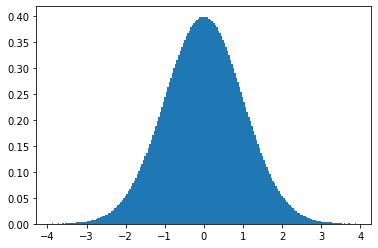

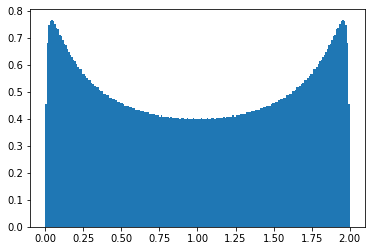

Text(0, 0.5, 'recall')

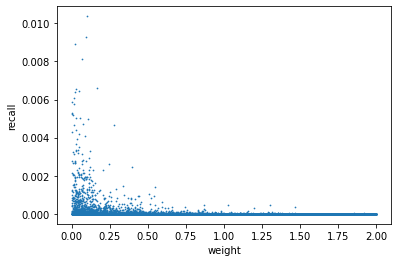

In [18]:
import matplotlib.pyplot as plt
device = "cuda:0"
from train_body import es, model
from dataset.common import MovieLenDataset, covert_csr_to_torch

model.load_state_dict(es.get_best()["model_state_dict"])

#model.cuda()
model.adversary.train()
item = covert_csr_to_torch(train_loader.train_original.transpose()).to(device)
#print(model.adversary.norm[0].running_mean)
model.adversary.eval()
weight_item = model.adversary(item, before_sigmoid=True).detach().cpu().numpy()
plt.hist(weight_item, bins=200, density=True)#, range=(-1,1))
plt.show()
weight_item = model.adversary(item).detach().cpu().numpy()
weight_item = list(model.adversary.normalize(model.item_weight).detach().cpu().numpy())
weight_item = model.adversary.normalize(model.item_weight).detach().cpu().numpy()

plt.hist(weight_item, bins=200, density=True,)
plt.show()
loss = (model.item_loss/ model.loss_count).detach().cpu().numpy()
plt.scatter(x=weight_item, y=-loss, s=0.5)
plt.xlabel("weight")
plt.ylabel("recall")
#print(list((model.item_loss / model.loss_count).detach().cpu().numpy())[2000:2100])